In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from statsbombpy import sb
from mplsoccer import VerticalPitch

In [14]:
# getting Statsbomb data from the 2022 world cup final
# Sorted in numerical and chronological order

wc_final_2022 = sb.events(match_id = 3869685).sort_values(by=['index'])
wc_final_2022['team'].unique()

array(['Argentina', 'France'], dtype=object)

In [16]:
# Splitting the data set to seperate the events by both teams

arg = wc_final_2022[wc_final_2022['team'] == "Argentina"]
fra = wc_final_2022[wc_final_2022.team == "France"]

In [17]:
# Defining global variables/constants

FRA_COLOR = '#002654'
ARG_COLOR = '#43A1D5'

FRA_TEAM_ID = 771
ARG_TEAM_ID = 779

In [150]:
# remove penalty shootout (period 5) to not confuse the data and show false results 
#from data that happened in the actual match

wc_final_2022 = wc_final_2022[wc_final_2022.period < 5]

wc_final_22 = sb.events(match_id = 3869685).sort_values(by=['index'])
df_pen = wc_final_22[wc_final_22.period == 5]
df_pen
#df_pen.columns
wc_final_2022.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_offensive', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_other', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_penalty', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'foul_won_penalty', 'goalkeeper_body_part',
       'goalkeeper_end_location', 'goalkeeper_outcome', 'goalkeeper_position',
       'goalkeeper_technique', 'goalkeeper_type', 'id', 'index',
       'interception_outcome', 'location', 'match_id', 'minute', 'off_camera',
       'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id'

In [48]:
# function to create the shotmap for each team
def create_shotmap(team, ax):
    pitch = VerticalPitch(pitch_type='statsbomb', half=True)
    pitch.draw(ax=ax)
    
    # the shots data is in the 'type' column
    team = team[team['type']=='Shot']
    
    # Filter down to just the columns we need
    team = team[['team', 'player', 'location', 'shot_outcome', 'shot_statsbomb_xg', 'shot_type']]
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    # Draw the shotmap
    for x in team.to_dict(orient='records'):
    
        pitch.scatter(
            x=x['x'], y=x['y'], ax=ax, 
            s=500 * x['shot_statsbomb_xg'], 
            color='green' if x['shot_outcome'] == 'Goal' else 'white', 
            edgecolors='black', alpha=0.7
        )

In [49]:
# function to create the pass network for each team
def create_passnetwork(team, ax):
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    tactics = team[~team['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
        
    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
    
    # Make a new, single column for time and sort the events in chronological order
    team["newsecond"] = 60 * team["minute"] + team["second"]
    
    team.sort_values(by=['newsecond'])
    
    # identify the passer and then the recipient, who'll be the playerId of the next action
    team['passer'] = team['player_id']
    
    team['recipient'] = team['passer'].shift(-1)
    
    # filter for only passes and then successful passes
    passes_df = team.loc[(team['type']=="Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
    
    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
    
    #find time of the team's first substitution and filter the df to only passes before that
    sub_df = team.loc[(team['type'] == "Substitution")]
    first_sub = sub_df["newsecond"].min()
    
    if first_sub <= (60 * 45):
        first_sub = 60 * 45
    
    completions = completions.loc[completions['newsecond'] < first_sub]
    
    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
    average_locs_and_count.columns = ['x', 'y', 'count']
    
    # find number of passes along each 'path' of passer to recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )
    
    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
    # plot arrows
    def pass_line_template(ax, x, y, end_x, end_y, line_color):
        ax.annotate(
            '',
            xy=(end_y,  end_x),
            xytext=(y, x),
            zorder=1,
            arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
        )
        
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y-y, end_x-x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
    pitch = VerticalPitch(pitch_type='statsbomb')
    pitch.draw(ax=ax)
    
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
    
    # plot nodes
    pitch.scatter(
        average_locs_and_count.x, average_locs_and_count.y, s=500,
        color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
    )
    
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(
            jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
            xy=(row.x, row.y),
            c='#132743',
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=ax
        )


In [51]:
# function to create the summary statistics table for the match
def create_table(team1, team2):
    # Drop rows where the pass_outcome is Unknown
    team1 = team1[team1['pass_outcome'] != 'Unknown']
    team2 = team2[team2['pass_outcome'] != 'Unknown']
    
    # Create a table with the data
    # We first need to calculate the statistics for each team
    # we will calcualte the following stats:
    # - goals
    # - xG
    # - shots
    # - shots on target
    # - passes
    # - pass completion %
    
    # Create a dictionary to store the stats
    stats = {
        'goals': {'team1': len(team1[team1['type'] == 'Goal']), 'team2': len(team2[team2['type'] == 'Goal'])},
        'xG': {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
        'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
        'shots_on_target': {
            'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
            'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
        },
        'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
        'pass_completion': {
            'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
            'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)
        }
    }
    
    # store as a dataframe
    stats_df = pd.DataFrame(stats).T

    column_labels = ['', '', '']
    table_vals = [
        [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
        [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
        [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
        [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
        [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
    ]
    
    return column_labels, table_vals

In [58]:
# function to create the xG flow chart for the match
def create_xg_flow_chart(df, ax):
    # We'll use the original df instead of the team1 and team2 dataframes
    
    # Filter the columns to only shots
    df = df[df['type'] == 'Shot']
    
    # Sort the values so they are in order of time
    df = df.sort_values(by="index")
    
    # Calculate the cumulative xG for each team
    df['cumulative_xG'] = df.groupby('team_id')['shot_statsbomb_xg'].cumsum()
    
    # Plot the xG for each team by half
    # We want to make it so the lines both start at 0
    for team in df['team_id'].unique():
        
        team_df = df[df['team_id'] == team]
        
        # add a 0 xG row at the start of the match
        team_df = pd.concat([pd.DataFrame({
            'team_id': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': None, 'cumulative_xG': 0, 'period': 1
        }, index=[0]), team_df])
        
        ax.plot(
            team_df['minute'], 
            team_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=ARG_COLOR if team == ARG_TEAM_ID else FRA_COLOR
        )   
            
    
    # We Can add a scatter plot to show the goals
    for team in df['team_id'].unique():
        team_df = df[(df['team_id'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient='records')
        for x in team_df:
            ax.scatter(
                x['minute'], 
                x['cumulative_xG'], 
                c='white',
                edgecolor=ARG_COLOR if team == ARG_TEAM_ID else FRA_COLOR,
                s=100,
                # We want the goals to be on top of the lines
                zorder=5
            )
            
            # add a label to the goals for the player who scored
            ax.text(
                x['minute'], 
                x['cumulative_xG'] - .07, 
                x['player'], 
                ha='center', 
                va='center', 
                fontfamily='monospace', 
                fontsize=8,
                zorder=10
            )
            
    # Let's label the x axis with first and second half
    ax.set_xticks([0, 45, 90, 120])
    ax.set_xticklabels(['0\'', '45\'', '90\'', '120\''])
    
    # Let's get rid of the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/1423491005.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/1423491005.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


(np.float64(-4.0), np.float64(84.0), np.float64(56.0), np.float64(124.0))

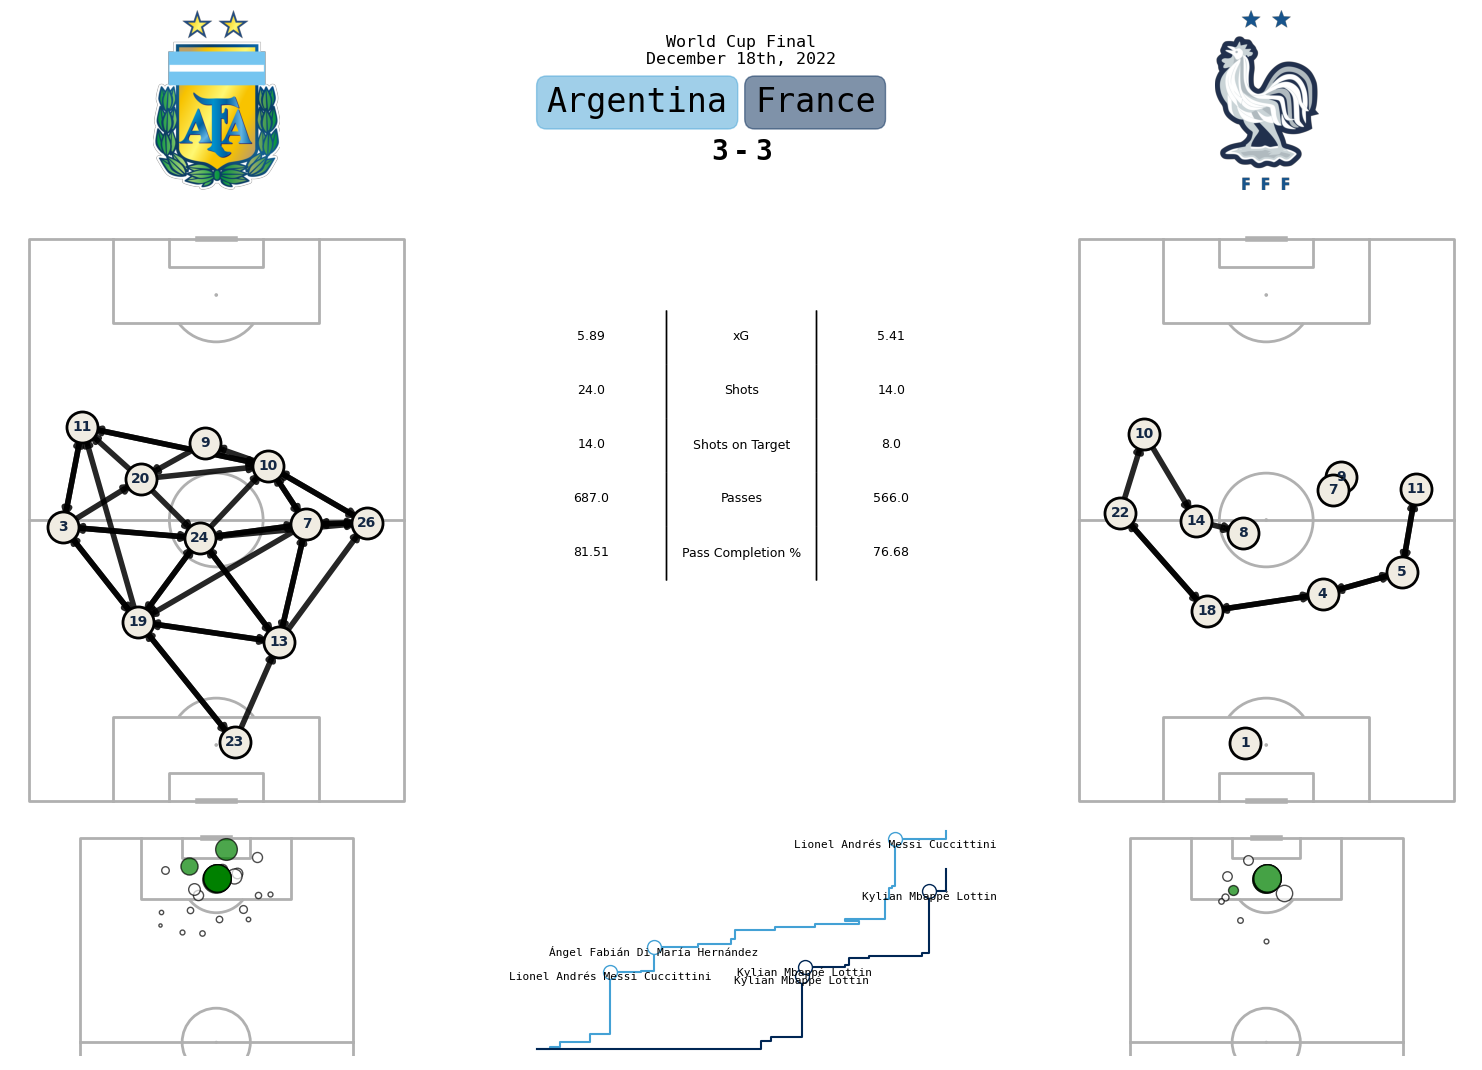

In [65]:
# setting up the match dashboard figure

fig = plt.figure(figsize = (15, 12))

# Team 1 Logo 
ax1 = fig.add_axes([.225, .775, .15, .15])
team1_img = Image.open('/Users/oliverdaboo/Desktop/football_analytics_courses/complete_football_analytics/complete-football-analytics-main/team_logos/argentina_logo.png')
ax1.imshow(team1_img)
ax1.axis('off')

# Match teams, event, date, and score
ax2 = fig.add_axes([.5, .8, .3, .1])

# event and date
ax2.text(.5, .8, 'World Cup Final\nDecember 18th, 2022', fontsize=12, ha='center',
         fontdict={'family': 'monospace'})

# Argentina highlighted text
team_1_text = ax2.text(.47, .4, 'Argentina', fontsize=24, ha='right', 
                       fontdict={'family': 'monospace'})
team_1_text.set_bbox(dict(facecolor=ARG_COLOR, alpha=.5, edgecolor=ARG_COLOR, 
                          boxstyle='round'))

# France highlighted text
team_2_text = ax2.text(.53, .4, 'France', fontsize=24, ha='left', 
                       fontdict={'family': 'monospace'})
team_2_text.set_bbox(dict(facecolor=FRA_COLOR, alpha=.5, edgecolor=FRA_COLOR, 
                          boxstyle='round'))

# Score
ax2.text(.47, 0, '3', fontsize=20, ha='right', fontdict={'family': 'monospace', 
                                                         'weight': 'bold'})
ax2.text(.5, 0, '-', fontsize=20, ha='center', fontdict={'family': 'monospace', 
                                                         'weight': 'bold'})
ax2.text(.53, 0, '3', fontsize=20, ha='left', fontdict={'family': 'monospace', 
                                                         'weight': 'bold'})
ax2.axis('off')

# Team 2 Logo
ax3 = fig.add_axes([.925, .775, .15, .15])
team2_img = Image.open('/Users/oliverdaboo/Desktop/football_analytics_courses/complete_football_analytics/complete-football-analytics-main/team_logos/france_logo.png')
ax3.imshow(team2_img)
ax3.axis('off')

# Team 1 Pass Network
ax4 = fig.add_axes([.15, .25, .3, .5])
create_passnetwork(arg, ax4)
ax4.axis('off')

# Summary Match Statistics Table
ax5 = fig.add_axes([.5, .2, .3, .5])
columns_labels, table_vals = create_table(arg, fra)
table = ax5.table(
    cellText=table_vals,
    cellLoc='center',
    edges='vertical',
    bbox=[0, .5, 1, .45]
)
table.set_fontsize(14)

# getting ridge of the edge lines on the table
for (i, j), cell in table.get_celld().items():
    if j == 0:
        table.get_celld()[(i, j)].visible_edges = 'R'
    elif j == 2:
        table.get_celld()[(i, j)].visible_edges = 'L'
    else:
        table.get_celld()[(i, j)].visible_edges = 'LR'
ax5.axis('off')

# Team 2 Pass Network
ax6 = fig.add_axes([.85, .25, .3, .5])
create_passnetwork(fra, ax6)
ax6.axis('off')

# Team 1 Shot Map
ax7 = fig.add_axes([.2, .05, .2, .2])
create_shotmap(arg, ax7)
ax7.axis('off')

# xG Flow Chart
ax8 = fig.add_axes([.5, .05, .3, .2])
create_xg_flow_chart(wc_final_2022, ax8)
ax8.axis('off')

# Team 2 Shot Map
ax9 = fig.add_axes([.9, .05, .2, .2])
create_shotmap(fra, ax9)
ax9.axis('off')

In [174]:
# Imports
import math
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from statsbombpy import sb
from mplsoccer import VerticalPitch
from matplotlib.lines import Line2D
import numpy as np



def create_match_dashboard(match_id, competition_name, match_date, team1_name, team2_name, team1_color, team2_color, show_team_badges=True,
                           team1_image=None, team2_image=None):
    # getting Statsbomb data from the desired match sorted in numerical and chronological order
    df = sb.events(match_id = match_id).sort_values(by=['index'])

    # Splitting the data set into the main match and penalty shootout to not confuse data in the seperate game states
    non_pen_df = df[df.period < 5]
    pen_df = df[df.period == 5]

    # checking if the match had a penalty shootout
    has_shootout = len(pen_df) > 0

     # Splitting the data set to seperate the events by both teams
    team1_df = non_pen_df[non_pen_df.team == team1_name]
    team2_df = non_pen_df[non_pen_df.team == team2_name]

    # Defining global variables/constants

    TEAM1_COLOR = team1_color
    TEAM2_COLOR = team2_color

    TEAM1_ID = non_pen_df[non_pen_df.team == team1_name]['team_id'].iloc[0]
    TEAM2_ID = non_pen_df[non_pen_df.team == team2_name]['team_id'].iloc[0]

    TEAM1_GOALS = len(non_pen_df[(non_pen_df.team == team1_name) & (non_pen_df.shot_outcome == 'Goal')])
    TEAM1_OG = len(non_pen_df[(non_pen_df.team == team2_name) & (non_pen_df.type == 'Own Goal Against')])
    TEAM1_SCORE = TEAM1_GOALS + TEAM1_OG
    
    # Goals scored by Team 2 (Shots + Own Goals by Team 1)
    TEAM2_GOALS = len(non_pen_df[(non_pen_df.team == team2_name) & (non_pen_df.shot_outcome == 'Goal')])
    TEAM2_OG = len(non_pen_df[(non_pen_df.team == team1_name) & (non_pen_df.type == 'Own Goal Against')])
    TEAM2_SCORE = TEAM2_GOALS + TEAM2_OG

    # function to create the shotmap for each team
    def create_shotmap(team, ax):
        pitch = VerticalPitch(pitch_type='statsbomb', half=True)
        pitch.draw(ax=ax)
        
        # Filter for shots only
        shots = team[team['type'] == 'Shot'].copy()
        
        # Split location into x and y
        shots[['x', 'y']] = shots['location'].apply(pd.Series)
        
        # Draw the shotmap
        for _, shot in shots.iterrows():
            # Logic for coloring:
            # 1. Goal -> Green
            # 2. Saved (On Target but no goal) -> Red
            # 3. Everything else (Off Target, Blocked, etc.) -> White
            if shot['shot_outcome'] == 'Goal':
                color = 'green'
            elif shot['shot_outcome'] == 'Saved':
                color = 'red'
            else:
                color = 'white'
                
            pitch.scatter(
                x=shot['x'], 
                y=shot['y'], 
                ax=ax, 
                s=500 * shot['shot_statsbomb_xg'], 
                color=color, 
                edgecolors='black', 
                alpha=0.7,
                zorder=2
            )

        # Create Legend Handles
        # Color handles
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Goal',
                   markerfacecolor='green', markeredgecolor='black', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Saved',
                   markerfacecolor='red', markeredgecolor='black', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Miss/Blocked',
                   markerfacecolor='white', markeredgecolor='black', markersize=10),
        ]
        
        # Size handles (xG Scale)
        # We use sqrt because markersize in Line2D is diameter, while 's' in scatter is area
        for xg_val in [0.1, 0.5]:
            size = np.sqrt(500 * xg_val)
            legend_elements.append(
                Line2D([0], [0], marker='o', color='w', label=f'{xg_val} xG',
                       markerfacecolor='gray', markeredgecolor='black', markersize=size)
            )
        
        # Adding the legend to the axis
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.2),
                  ncol=3, fontsize=8, frameon=False, handletextpad=0.1)

    
    # function to create the pass network for each team
    def create_passnetwork(team, ax):
        team[['x', 'y']] = team['location'].apply(pd.Series)
        
        tactics = team[~team['tactics'].isnull()][['tactics', 'team']]
    
        all_jersey_numbers = []
        for y in tactics.to_dict(orient='records'):
            all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
            
        jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
        
        # Make a new, single column for time and sort the events in chronological order
        team["newsecond"] = 60 * team["minute"] + team["second"]
    
        team.sort_values(by=['newsecond'])
        
        # identify the passer and then the recipient, who'll be the playerId of the next action
        team['passer'] = team['player_id']
        
        team['recipient'] = team['passer'].shift(-1)
        
        # filter for only passes and then successful passes
        passes_df = team.loc[(team['type']=="Pass")]
        passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
        
        completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
        
        #find time of the team's first substitution and filter the df to only passes before that
        sub_df = team.loc[(team['type'] == "Substitution")]
        first_sub = sub_df["newsecond"].min()
        
        if first_sub <= (60 * 45):
            first_sub = 60 * 45
        
        completions = completions.loc[completions['newsecond'] < first_sub]
        
        # Find Average Locations
        average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
        average_locs_and_count.columns = ['x', 'y', 'count']
        
        # find number of passes along each 'path' of passer to recipient
        passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
        passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
        
        passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
        passes_between = passes_between.merge(
            average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
        )
        
        # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
        passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
        # plot arrows
        def pass_line_template(ax, x, y, end_x, end_y, line_color):
            ax.annotate(
                '',
                xy=(end_y,  end_x),
                xytext=(y, x),
                zorder=1,
                arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
            )
            
        def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
            dist = math.hypot(end_x - x, end_y - y)
            angle = math.atan2(end_y-y, end_x-x)
            upd_x = x + (dist - dist_delta) * math.cos(angle)
            upd_y = y + (dist - dist_delta) * math.sin(angle)
            pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
        pitch = VerticalPitch(pitch_type='statsbomb')
        pitch.draw(ax=ax)
        
        for index, row in passes_between.iterrows():
            pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
        
        # plot nodes
        pitch.scatter(
            average_locs_and_count.x, average_locs_and_count.y, s=500,
            color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
        )
        
        for index, row in average_locs_and_count.iterrows():
            pitch.annotate(
                jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
                xy=(row.x, row.y),
                c='#132743',
                va='center',
                ha='center',
                size=10,
                fontweight='bold',
                ax=ax
            )
            
    # function to calculate time of possession for both teams
    def calculate_possession_time(df, team1_name, team2_name):
        # 1. Create a total seconds column for easy math
        df['total_seconds'] = df['minute'] * 60 + df['second']
    
        # 2. Sort chronologically
        df = df.sort_values(['period', 'timestamp', 'index'])
        
        # 3. Calculate time difference between this event and the NEXT one
        # This represents the "active time" assigned to the current possession team
        df['time_delta'] = df['total_seconds'].shift(-1) - df['total_seconds']
        
        # 4. Clean up period transitions (e.g., time between 45:00 and 45:00 of next half)
        # We set deltas to 0 if the next event is in a different period
        df.loc[df['period'] != df['period'].shift(-1), 'time_delta'] = 0
        
        # 5. Sum the time_delta based on the 'possession_team' column
        # StatsBomb identifies who 'owns' the ball during every event
        possession_sums = df.groupby('possession_team')['time_delta'].sum()
        
        # 6. Extract totals and calculate percentage
        t1_time = possession_sums.get(team1_name, 0)
        t2_time = possession_sums.get(team2_name, 0)
        
        total_time = t1_time + t2_time
        
        if total_time > 0:
            t1_percent = round((t1_time / total_time) * 100)
            t2_percent = 100 - t1_percent
        else:
            t1_percent, t2_percent = 50, 50
            
        return t1_percent, t2_percent

        # function to create the summary statistics table for the match
    def create_table(team1, team2):
        # Drop rows where the pass_outcome is Unknown
        team1 = team1[team1['pass_outcome'] != 'Unknown']
        team2 = team2[team2['pass_outcome'] != 'Unknown']

        # calculating time of possession using the above function
        t1_pos, t2_pos = calculate_possession_time(non_pen_df, team1_name, team2_name)
        
        # Create a table with the data
        # We first need to calculate the statistics for each team
        # we will calcualte the following stats:
        # - goals
        # - xG
        # - shots
        # - shots on target
        # - passes
        # - pass completion %
    
        # Create a dictionary to store the stats
        stats = {
            'goals': {'team1': len(team1[team1['type'] == 'Goal']), 'team2': len(team2[team2['type'] == 'Goal'])},
            'xG': {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
            'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
            'shots_on_target': {
                'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
                'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
            },
            'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
            'pass_completion': {
                'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
                'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)
            }
        }
        
        # store as a dataframe
        stats_df = pd.DataFrame(stats).T
    
        column_labels = ['', '', '']
        table_vals = [
            [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
            [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
            [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
            [f"{t1_pos}%", 'Possession (Time %)', f"{t2_pos}%"],
            [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
            [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
        ]
        
        return column_labels, table_vals

    # function to create the xG flow chart for the match
    def create_xg_flow_chart(df, ax):
        # Preparing Shot Data for the lines
        shots = df[df['type'] == 'Shot'].sort_values(by="index").copy()
        shots['cumulative_xG'] = shots.groupby('team_id')['shot_statsbomb_xg'].cumsum()

        # Plotting the lines for each team
        for team in df['team_id'].unique():
            team_shots = shots[shots['team_id'] == team]
            color = TEAM1_COLOR if team == TEAM1_ID else TEAM2_COLOR
            
            # Add a 0 xG row at the start
            start_row = pd.DataFrame({
                'team_id': team, 'minute': 0, 'cumulative_xG': 0
            }, index=[0])
            team_shots = pd.concat([start_row, team_shots])
            
            ax.plot(
                team_shots['minute'], 
                team_shots['cumulative_xG'], 
                drawstyle='steps-post',
                c=color,
                linewidth=2,
                zorder=2
            )

            # Plotting Goals (Filled Green)
            team_goals = team_shots[team_shots['shot_outcome'] == 'Goal']
            for _, goal in team_goals.iterrows():
                ax.scatter(goal['minute'], goal['cumulative_xG'], 
                           c='green', edgecolor='black', s=100, zorder=5)
                # Name next to the dot (offset slightly)
                ax.text(goal['minute'] + 1.5, goal['cumulative_xG'], goal['player'], 
                        fontsize=8, va='center', fontweight='bold', fontfamily='monospace')
                
            # Helper function to find xG at a specific minute for non-shot events
            def get_xg_at_minute(m):
                prev = team_shots[team_shots['minute'] <= m]
                return prev['cumulative_xG'].iloc[-1] if not prev.empty else 0
    
            # Cards (Yellow and Red)
            card_cols = ['foul_committed_card', 'bad_behaviour_card']
            available_cols = [c for c in card_cols if c in df.columns]
            
            if available_cols:
                cards = df[(df['team_id'] == team) & (df['type'].isin(['Foul Committed', 'Bad Behaviour']))].copy()
                # Combine card columns
                cards['card_type'] = cards[available_cols[0]] if len(available_cols) == 1 else cards[available_cols[0]].fillna(cards[available_cols[1]])
                
                for _, card in cards[cards['card_type'].notna()].iterrows():
                    curr_xg = get_xg_at_minute(card['minute'])
                    card_color = 'yellow' if 'Yellow' in card['card_type'] else 'red'
                    
    
                    ax.scatter(card['minute'], curr_xg, marker='s', s=60, 
                               facecolor=card_color, alpha=0.5, edgecolor='black', linewidth=1, zorder=6)
    
            # Substitutions
            subs = df[(df['team_id'] == team) & (df['type'] == 'Substitution')]
            for _, sub in subs.iterrows():
                curr_xg = get_xg_at_minute(sub['minute'])
                # Plot a Blue Triangle (marker='^')
                ax.scatter(sub['minute'], curr_xg, marker='^', s=70, 
                           facecolor='blue', alpha=0.5, edgecolor='white', linewidth=1, zorder=6)
                
        # Styling and Legend
        ax.set_xticks([0, 15, 30, 45, 60, 75, 90, 105, 120])
        ax.set_xticklabels(['0\'', '15\'', '30\'', '45\'', '60\'', '75\'', '90\'', '105\'', '120\''])
        
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Goal', markerfacecolor='green', markersize=10),
            Line2D([0], [0], marker='s', color='w', label='Yellow Card', markerfacecolor='yellow', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Red Card', markerfacecolor='red', markersize=8),
            Line2D([0], [0], marker='^', color='w', label='Sub', markerfacecolor='blue', markersize=8)
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.45), 
                  ncol=4, fontsize=9, frameon=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    def create_penalty_shootout_chart(pen_df, ax):
        # Getting just the shots in the shootout
        pen_shots = pen_df[pen_df['type'] == 'Shot']
        
        # Sort chronologically and determine order
        pen_shots = pen_shots.sort_values(by='index')
        first_team = pen_shots.iloc[0]['team']
        second_team = team2_name if first_team == team1_name else team1_name
        
        # Calculate rounds per team
        pen_shots['round'] = pen_shots.groupby('team').cumcount() + 1
        max_rounds = pen_shots['round'].max()
        
        # Plot outcomes
        y_map = {first_team: 1, second_team: 0}
        for _, row in pen_shots.iterrows():
            if row['shot_outcome'] == 'Goal': color = 'green'
            elif row['shot_outcome'] == 'Saved': color = 'red'
            else: color = 'white'
            ax.scatter(row['round'], y_map[row['team']], color=color, 
                       edgecolors='black', s=350, zorder=3)
            
        # Labels and formatting
        ax.text(0, 1, first_team, ha='right', va='center', fontsize=12, 
                fontweight='bold', fontfamily='monospace')
        ax.text(0, 0, second_team, ha='right', va='center', fontsize=12, 
                fontweight='bold', fontfamily='monospace')

        # 5. Legend 
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Goal', 
                   markerfacecolor='green', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Saved', 
                   markerfacecolor='red', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='No Goal', 
                   markerfacecolor='white', markeredgecolor='black', markersize=8)
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 1.2), 
                  ncol=3, fontsize=9, frameon=False, handletextpad=0.1)
        
        # Win Text
        t1_pens = len(pen_shots[(pen_shots.team == team1_name) & (pen_shots.shot_outcome == 'Goal')])
        t2_pens = len(pen_shots[(pen_shots.team == team2_name) & (pen_shots.shot_outcome == 'Goal')])
        pen_winner = team1_name if t1_pens > t2_pens else team2_name
        result_str = f" {pen_winner} wins in a Penalty Shootout {t1_pens}-{t2_pens}!"
        
        # Center coordinate is (1 + max_rounds) / 2
        ax.text((1 + max_rounds) / 2, -1.3, result_str, ha='center', fontsize=18, 
                fontweight='bold', fontfamily='monospace',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.6'))

        ax.set_xlim(-3, max_rounds + 1)
        ax.set_ylim(-2.0, 2.3)
        ax.axis('off')

    # setting up the match dashboard figure

    y_offset = 0.22 if has_shootout else 0
    fig_height = 16 if has_shootout else 12
    fig = plt.figure(figsize=(15, fig_height))
    
    # Team 1 Logo (Conditional)
    if show_team_badges:
        ax1 = fig.add_axes([.05, .775 + (y_offset * 0.8), .15, .15])
        team1_img = Image.open(team1_image)
        ax1.imshow(team1_img)
        ax1.axis('off')
    
    # Match teams, event, date, and score
    ax2 = fig.add_axes([.45, .8 + (y_offset*0.8), .3, .1])
    
    # event and date
    ax2.text(.5, .8, f'{competition_name}\n{match_date}', fontsize=12, ha='center',
             fontdict={'family': 'monospace'})
    
    # Argentina highlighted text
    team_1_text = ax2.text(.47, .4, team1_name, fontsize=24, ha='right', 
                           fontdict={'family': 'monospace'})
    team_1_text.set_bbox(dict(facecolor=TEAM1_COLOR, alpha=.5, edgecolor=TEAM1_COLOR, 
                              boxstyle='round'))

    # France highlighted text
    team_2_text = ax2.text(.53, .4, team2_name, fontsize=24, ha='left', 
                           fontdict={'family': 'monospace'})
    team_2_text.set_bbox(dict(facecolor=TEAM2_COLOR, alpha=.5, edgecolor=TEAM2_COLOR, 
                              boxstyle='round'))
    
    # Score
    ax2.text(.47, 0, str(TEAM1_SCORE), fontsize=20, ha='right', fontdict={'family': 'monospace', 
                                                             'weight': 'bold'})
    ax2.text(.5, 0, '-', fontsize=20, ha='center', fontdict={'family': 'monospace', 
                                                             'weight': 'bold'})
    ax2.text(.53, 0, str(TEAM2_SCORE), fontsize=20, ha='left', fontdict={'family': 'monospace', 
                                                             'weight': 'bold'})
    ax2.axis('off')
    
    # Team 2 Logo (Conditional)
    if show_team_badges:
        ax3 = fig.add_axes([.925, .775 + (y_offset * 0.8), .15, .15])
        team2_img = Image.open(team2_image)
        ax3.imshow(team2_img)
        ax3.axis('off')
    
    # Team 1 Pass Network
    ax4 = fig.add_axes([.05, .25 + (y_offset*0.8), .35, .5])
    create_passnetwork(team1_df, ax4)
    ax4.axis('off')
    
    # Summary Match Statistics Table
    ax5 = fig.add_axes([.45, .2 + (y_offset*0.8), .3, .5])
    columns_labels, table_vals = create_table(team1_df, team2_df)
    table = ax5.table(
        cellText=table_vals,
        cellLoc='center',
        edges='vertical',
        bbox=[0, .5, 1, .45]
    )
    table.set_fontsize(14)
    
    # getting ridge of the edge lines on the table
    for (i, j), cell in table.get_celld().items():
        if j == 0:
            table.get_celld()[(i, j)].visible_edges = 'R'
        elif j == 2:
            table.get_celld()[(i, j)].visible_edges = 'L'
        else:
            table.get_celld()[(i, j)].visible_edges = 'LR'
    ax5.axis('off')
    
    # Team 2 Pass Network
    ax6 = fig.add_axes([.85, .25 + (y_offset*0.8), .3, .5])
    create_passnetwork(team2_df, ax6)
    ax6.axis('off')
    
    # Team 1 Shot Map
    ax7 = fig.add_axes([.05, .05 + (y_offset*0.8), .2, .2])
    create_shotmap(team1_df, ax7)
    ax7.axis('off')
    
    # xG Flow Chart
    ax8 = fig.add_axes([.45, .15 + (y_offset*0.8), .3, .2])
    create_xg_flow_chart(non_pen_df, ax8)
    
    # Team 2 Shot Map
    ax9 = fig.add_axes([.9, .05 + (y_offset*0.8), .2, .2])
    create_shotmap(team2_df, ax9)
    ax9.axis('off')

    # Shootout (If applicable)
    if has_shootout:
        ax_pen = fig.add_axes([0.1, 0.02, 0.8, 0.12])
        create_penalty_shootout_chart(pen_df, ax_pen)

    return fig
        

/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/3147838933.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team[['x', 'y']] = team['location'].apply(pd.Series)
/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/3147838933.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team[['x', 'y']] = team['location'].apply(pd.Series)
/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/3147838933.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy

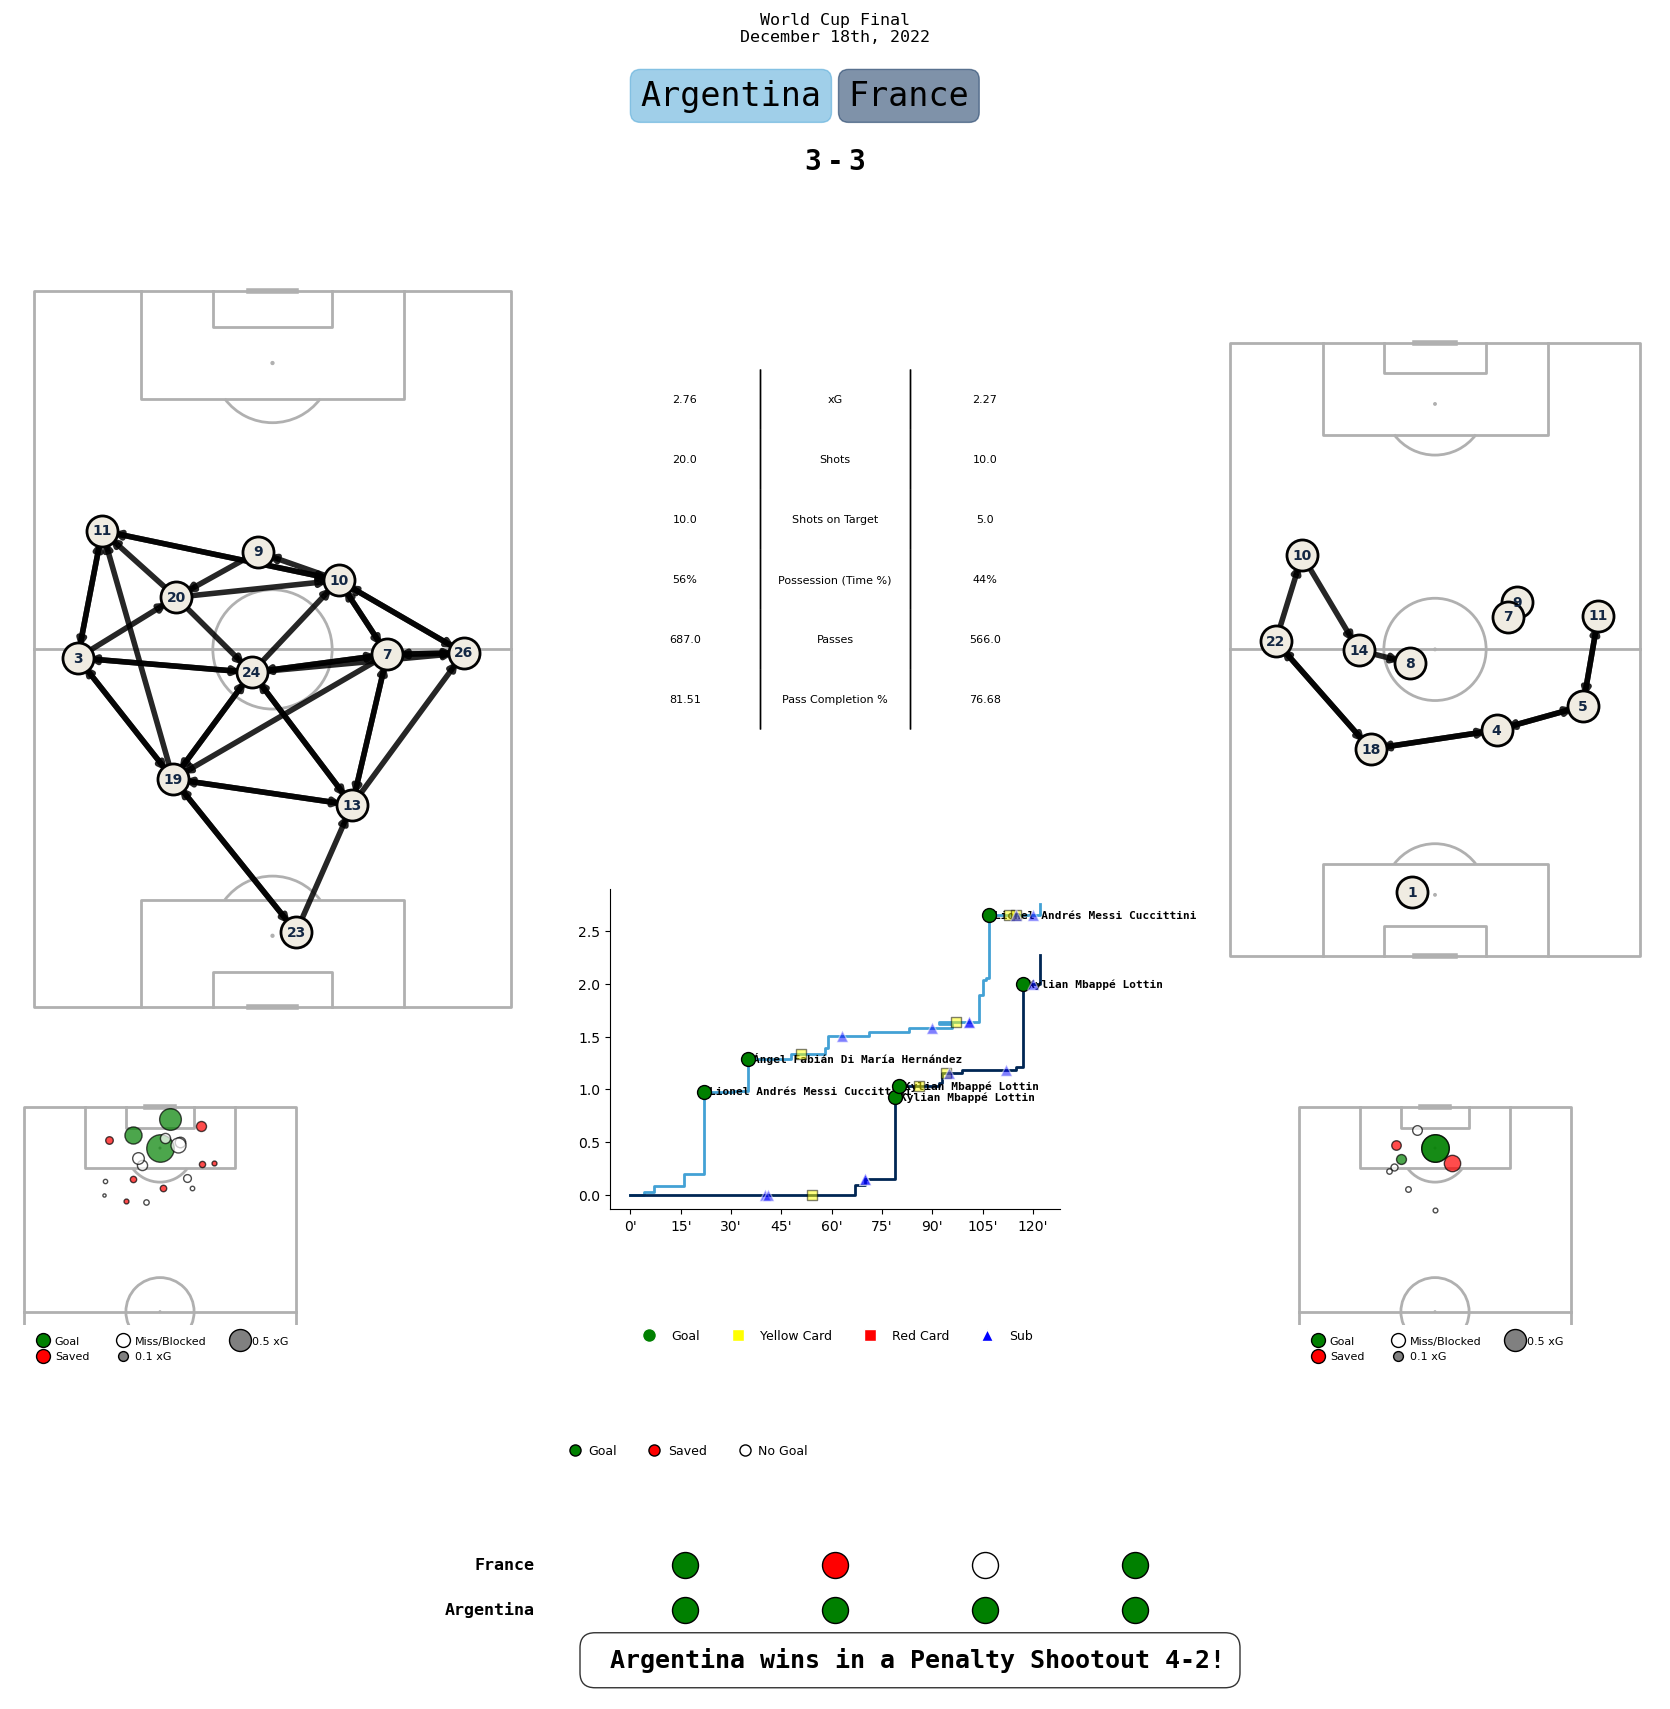

In [177]:
# # world_cup_final_2022_dashboard = create_match_dashboard(match_id = 3869685, competition_name='World Cup Final', 
#                                 match_date='December 18th, 2022', team1_name='Argentina', team2_name='France', team1_color='#43A1D5', 
#                                 team2_color='#002654', show_team_badges=True,
#                                 team1_image='/Users/oliverdaboo/Desktop/football_analytics_courses/complete_football_analytics/complete-football-analytics-main/team_logos/argentina_logo.png',
#                                team2_image='/Users/oliverdaboo/Desktop/football_analytics_courses/complete_football_analytics/complete-football-analytics-main/team_logos/france_logo.png'
#                       )

world_cup_final_2022_dashboard = create_match_dashboard(match_id = 3869685, competition_name='World Cup Final', 
                                match_date='December 18th, 2022', team1_name='Argentina', team2_name='France', team1_color='#43A1D5', 
                                team2_color='#002654', show_team_badges=False)

save_path = '/Users/oliverdaboo/Desktop/world_cup_final_dashboard.png'

world_cup_final_2022_dashboard.savefig(save_path, dpi=300, bbox_inches='tight')
                       

In [172]:
sb_competitions = sb.competitions()

world_cups = sb_competitions[sb_competitions['competition_name'] == 'FIFA World Cup']
print(world_cups)



    competition_id  season_id   country_name competition_name  \
29              43        106  International   FIFA World Cup   
30              43          3  International   FIFA World Cup   
31              43         55  International   FIFA World Cup   
32              43         54  International   FIFA World Cup   
33              43         51  International   FIFA World Cup   
34              43        272  International   FIFA World Cup   
35              43        270  International   FIFA World Cup   
36              43        269  International   FIFA World Cup   

   competition_gender  competition_youth  competition_international  \
29               male              False                       True   
30               male              False                       True   
31               male              False                       True   
32               male              False                       True   
33               male              False                   

In [178]:
wc_2022_matches = sb.matches(competition_id=43, season_id=106)


for match_id in wc_2022_matches['match_id']:
    f("{wc_2022_matches['home_team']}_{wc_2022_matches['home_team']}_dashboard") = create_match_dashboard(match_id = match_id, competition_name=wc_2022_matches['competition'], 
                                match_date=wc_2022_matches['match_date'], team1_name=wc_2022_matches['home_team'], 
                                team2_name=wc_2022_matches['away_team'], team1_color='#43A1D5', 
                                team2_color='#002654', show_team_badges=False)

In [183]:
england_wales = wc_2022_matches[wc_2022_matches['match_id'] == 3857261]
england_wales['match_date'].unique()

array(['2022-11-29'], dtype=object)

/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/3147838933.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team[['x', 'y']] = team['location'].apply(pd.Series)
/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/3147838933.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team[['x', 'y']] = team['location'].apply(pd.Series)
/var/folders/6r/jh3s_1bx5c38sq8s2g4jsh0m0000gn/T/ipykernel_83438/3147838933.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy

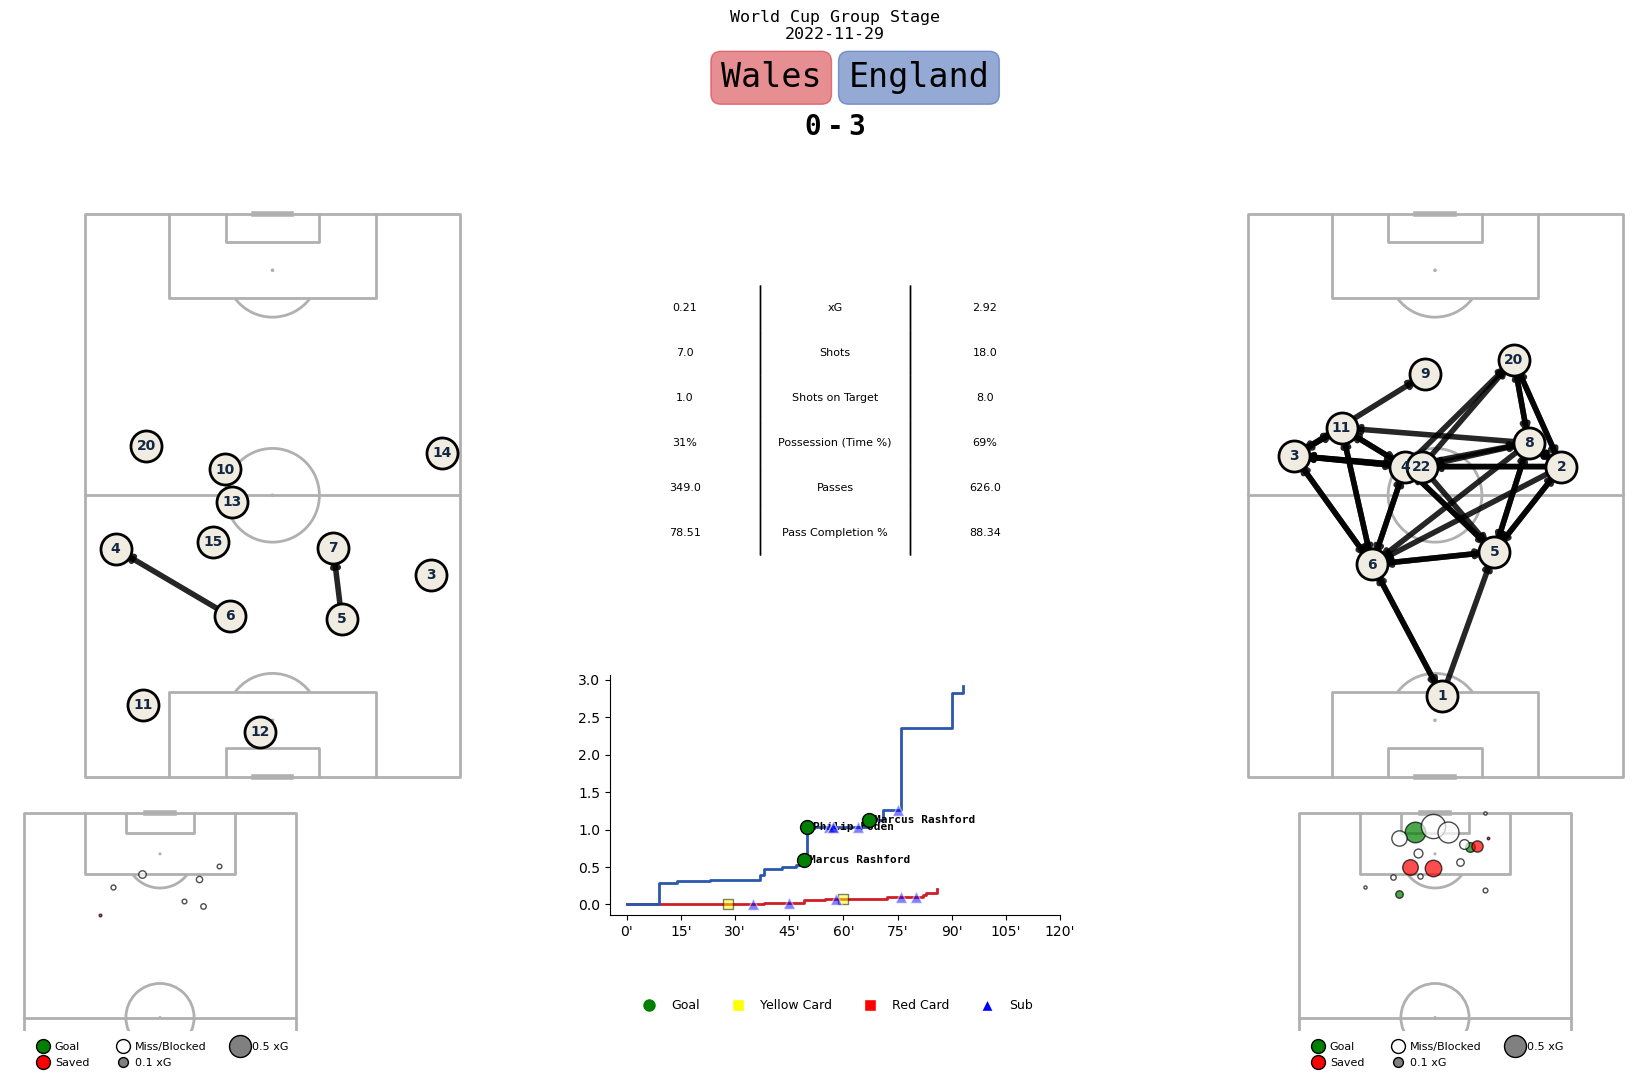

In [185]:
wales_england_dashboard = create_match_dashboard(match_id = 3857261, competition_name='World Cup Group Stage', 
                                match_date='2022-11-29', team1_name='Wales', team2_name='England', team1_color='#CF1E26', 
                                team2_color='#2B57AC', show_team_badges=False)

save_path = '/Users/oliverdaboo/Desktop/wales_england_dashboard.png'

wales_england_dashboard.savefig(save_path, dpi=300, bbox_inches='tight')